# Implementation of Siamese networks on the Fashion-MNIST dataset

### Imports

In [1]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Data collection and processing - Loading fashion dataset and creating pairs and labels

In [2]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
train_labels.shape

(60000,)

In [5]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [6]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

### Model creation

In [11]:
#base model
def model(): 
  #input layer of 28x28, three 128 dense layers
  input_layer = Input(shape=(28,28), name='base_model')
  flatten = Flatten(name="flatten")(input_layer)
  dense_1 = Dense(128, activation='relu', name='dense_1')(flatten)
  dropout = Dropout(0.1, name='dropout_1')(dense_1)
  dense_2 = Dense(128, activation='relu', name='dense_2')(dropout)
  dropout_1 = Dropout(0.1, name='dropout_2')(dense_2)
  dense_3 = Dense(128, activation='relu', name='dense_3')(dropout_1)
  model = Model(inputs=input_layer, outputs=dense_3)
  return model 

def distance(vectors): 
  x1, x2 = vectors
  return K.sqrt(K.maximum(K.sum(K.square(x1-x2),axis=1,keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)



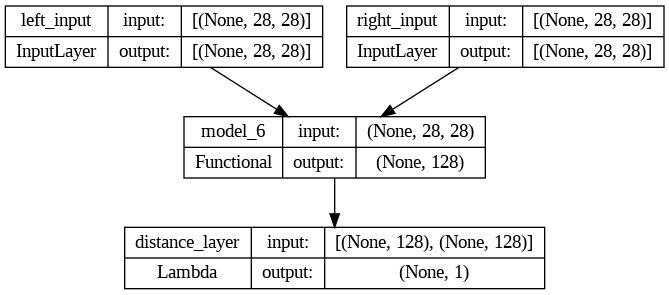

In [15]:
base_network = model() 

left_input = Input(shape=(28,28), name="left_input")
right_input = Input(shape=(28,28), name="right_input")

left_model = base_network(left_input)
right_model = base_network(right_input)

euclidian_layer = Lambda(distance, output_shape=eucl_dist_output_shape, name='distance_layer')([left_model, right_model])

siamese_net = Model(inputs=[left_input, right_input], outputs=euclidian_layer)

tf.keras.utils.plot_model(siamese_net, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [25]:
def loss_function(margin):
  def loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
  return loss 

In [26]:
rms = RMSprop() 
siamese_net.compile(loss=loss_function(margin=1), optimizer=rms)
history = siamese_net.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 15s 15ms/step - loss: 0.1125 - val_loss: 0.0906
Epoch 2/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0813 - val_loss: 0.0743
Epoch 3/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0728 - val_loss: 0.0765
Epoch 4/20
938/938 [==============================] - 11s 11ms/step - loss: 0.0682 - val_loss: 0.0685
Epoch 5/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0646 - val_loss: 0.0711
Epoch 6/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0620 - val_loss: 0.0669
Epoch 7/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0604 - val_loss: 0.0659
Epoch 8/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0587 - val_loss: 0.0662
Epoch 9/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0574 - val_loss: 0.0658
Epoch 10/20
938/938 [==============================] - 11s 11ms/step - loss: 0.056

In [28]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [30]:
loss = siamese_net.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = siamese_net.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = siamese_net.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 2s 3ms/step
Loss = 0.06361021101474762, Train Accuracy = 0.9399149858309719 Test Accuracy = 0.9143143143143143


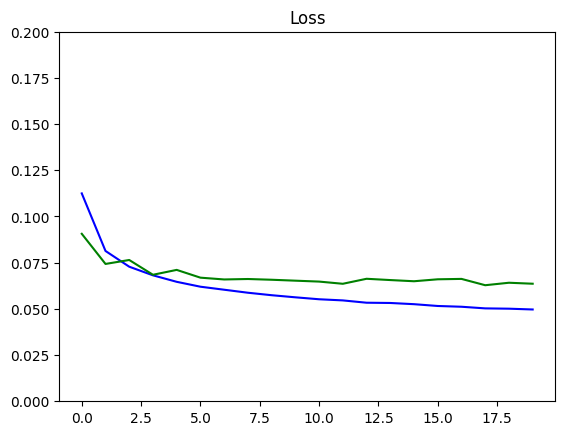

In [31]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [32]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)


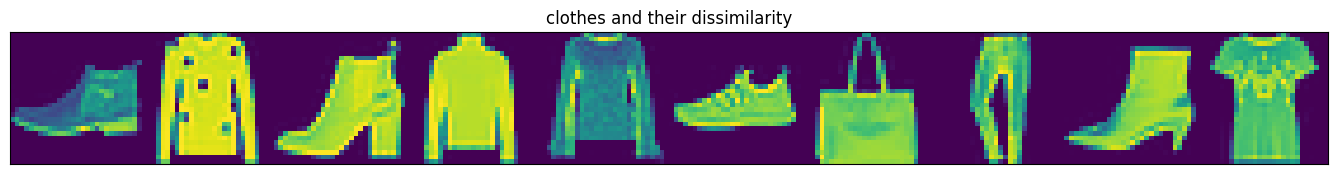

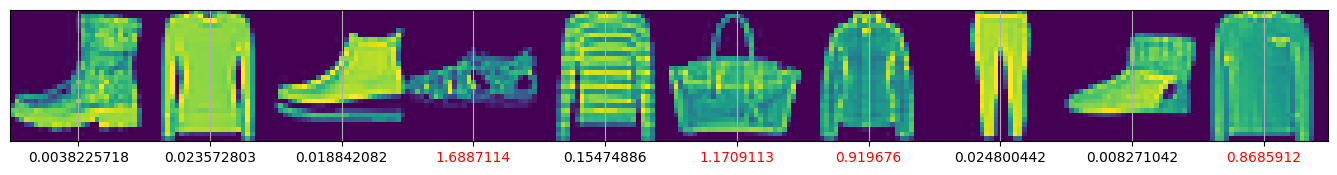

In [33]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)